# Fuzzy upravljanje poljoprivrednom proizvodnjom u plasteniku

<center><img src="Dinko.png" alt="drawing" width="50%"/></center>

### KRATAK OPIS PROBLEMA 
<p>
 Kao što nam je poznato u plastenicima i staklenicima se vrlo brzo mijenjaju klimatski uvjeti
 i zbog toga nam je potrebna automatska regulacija ventilacije (temperature) kako bi se potpuno iskoristila funkcionalnost objekata.

Zbog previsoke temperature u objektu dolazi do izduživanja internodija na biljkama dok preniska 
temperatura zaustavlja njezin rast. Kod ručnog otvaranja ventilacije nikad ne možemo pravovremeno 
odrediti kada je potrebno otvaranje ili zatvaranje ventilacije, a već mala zakašnjenja mogu dovesti do
 ekstremno visokih temperatura što je veliki šok za biljke.

Sa automatikom se ventilacija vrši postepenim otvaranjem prozora čime se onemogućavaju nagle 
promijene temperature koje uzrokuju šokiranje biljaka. Kod određene brzine i smjera vjetra automatika 
po potrebi pritvara ili zatvara ventilacijske otvore kako bi se spriječilo oštećenje objekta kod nevrjemena.<sup>[1](#izvori)</sup>
</p>

### DEFINICIJA ULAZNIH I IZLAZNIH VARIJABLI

Projekat bi bio realiziran na platformi Raspberry pi pico w, zbog svoje podrške za Python programski jezik i zato što ima ugrađen WiFi čip na sebi koji ćemo iskoristiti u projektu. U nastavku su definisane ulazne i izlazne varijable koje ćemo koristiti za mikrokontroler:

#### Ulazne varijable

Za naš fuzzy kontroler smo koristili 5 ulaznih varijabli:

1. **Varijabla:** Temperatura zraka  
   **Senzor:** `DHT 22`

2. **Varijabla:** Vlažnost zraka  
   **Senzor:** `DHT 22`

3. **Varijabla:** Brzina vjetra  
   **Senzor:** `Adafruit anemometar`

4. **Varijabla:** AQ indeks  
   **API:** [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com) (što je omotač za [AQICN API](https://aqicn.org/city/sarajevo/))

5. **Varijabla:** Da li pada kiša  
   **Senzor:** `Senzor za kišu`


#### Izlazne varijable

Izlazna varijabla je tipa **bool** i predstavlja signal mikrokontroleru da treba otvoriti prozore.

> ili

Izlazna varijabla je tipa **double** i predstavlja koliko će mikrokontroler otvoriti prozore.




### DEFINISANJE FUZZY SKUPOVA

1. **Varijabla:** Temperatura zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [-40°C, 80°C]<sup>[2](#izvori)</sup>  
   **Lingvistički model varijable:**  
   - `hladno`  []  
   - `taman`  []  
   - `vruće`  []  


2. **Varijabla:** Vlažnost zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0%, 100%]  
   **Lingvistički model varijable:**  
   - `suho`    []  
   - `taman`    []  
   - `vlažno`    []  


3. **Varijabla:** Brzina vjetra  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0 m/s, 32.4 m/s]  
   **Lingvistički model varijable:**  
   - `nema`    []  
   - `slab`    []  
   - `umjeren`    []  
   - `jak`  []  

4. **Varijabla:** AQ indeks  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0, +∞)  
   **Lingvistički model varijable:**<sup>[3](#izvori)</sup>
   - `dobro`    [0, 50]  
   - `umjereno`    [51, 100]  
   - `blago nezdravo`    [101, 150]  
   - `nezdravo`    [151, 200]  
   - `pravo nezdravo`    [201, 300]  
   - `opasno`  [301, +∞)  

5. **Varijabla:** Da li pada kiša  
   **Tip varijable:** `diskretna`  
   **Domen:** {0, 1}  
   **Lingvistički model varijable:**  
   - `ne pada kiša`  {0}
   - `pada kiša`  {1}


### IZRADA FUZZY PRAVILA

1. Ako je jak vjetar, zatvori
1. Ako umjeren vjetar i vlažan zrak, 
1. 
1. 
1. 
1. 
1. 
temp> -> otvori
temp< -> zatvori

brzina vjetra> -> zatvori
brzina vjetra< -> otvori

vlažnost zrala> -> otvori
vlažnost zraka< -> zatvori

AQI> -> zatvori
AQI< -> otvori ###

pada kiša i vlažnost< -> otvori?
pada kiša i vlažnost> -> zatvori?
ne pada kiša i vlažnost> -> otvori?
ne pada kiša i vlažnost< -> otvori?
ne pada kiša i vlažnost== -> zatvori?

Ako temp> i pada kiša -> otvori

balansiramo temp i vlažnost



AQI < pada kiša < brzina vjetra < vlažnost zrala < temp

Cilj: drzi prozore sto je duze otvorene.




### IMPLEMENTACIJA FUZZY SISTEMA i PRIKAZ REZULTATA

U nastavku imamo 3 python koda:

1. kod za server
1. kod za mikrokontroler
1. kod za demonstraciju u jupytr notebook-u

Prva 2 koda se neće moći i ne smiju se pokrenuti iz notebooka, jer nisu dizajnirani da se mogu završiti u njemu. Oni su programi koji u svojoj formi trebaju da se pokreću sa mikrokontrolera ili servera. Zato su zapisani u markdown čelijama, kako bi se mogli samo gledati, ali ne i izvršavati.

Kod za server na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com):

```python
from flask import Flask, request, jsonify
import requests

app = Flask(__name__)

with open(".secret", "r") as secret:
    WAQI_TOKEN = secret.read()
WAQI_URL_TEMPLATE = 'https://api.waqi.info/feed/{}/?token={}'

@app.route('/AQI', methods=['POST'])
def get_air_quality():
    data = request.get_json()
    
    if not data or 'grad' not in data:
        return jsonify({'error': 'Missing "grad" in request'}), 400

    grad = data['grad'].strip().lower()
    url = WAQI_URL_TEMPLATE.format(grad, WAQI_TOKEN)
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return jsonify(response.json())
    except requests.RequestException as e:
        return jsonify({'error': 'Failed to fetch data from WAQI API', 'details': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)

```

U nastavku je kod za mikrokontroler

```python
import time

def get_input():
    vektor = []
    # Citanje senzora i spremanje u vektor
    return vektor

# while True na mikrokontroleru 2 varijante
#varijanta s bool vrijednosti
def otvori_prozor():
    pass
def zatvori_prozor():
    pass

while True:
    if do_fuzzy(get_input()):
        otvori_prozor()
    else:
        zatvori_prozor()
    time.sleep(10)
    break

#varijanta s float vrijednost
def postavi_otvorenost_prozora_na(val):
    pass
while True:
    postavi_otvorenost_prozora_na(do_fuzzy(get_input()))
    time.sleep(10)
```

U nastavku ćemo imati interaktivni kod.

{'AQI': 0, 'DaLiPadaKisa': False, 'BrzinaVjetra': 0, 'VlaznostZraka': 0, 'TemperaturaZraka': 0}
[0 0 0 0 0]
Inputs before compute: temperature : 35
humidity : 30



/home/zlatan/Desktop/greenhouse-fuzzy-window-controller/venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0

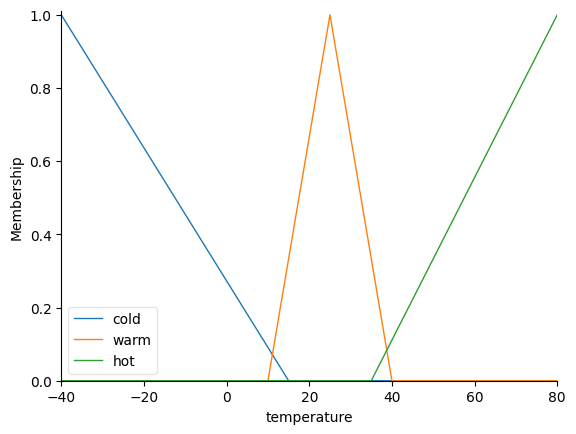

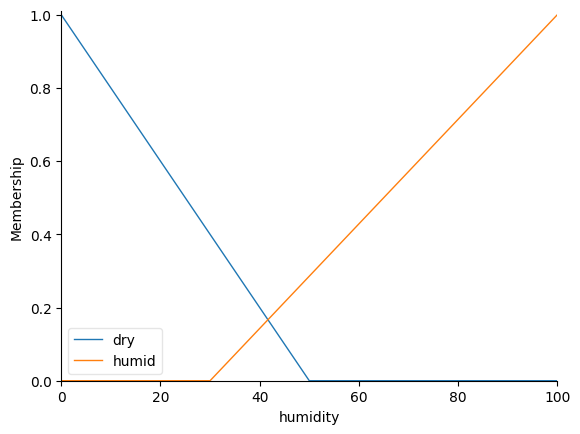

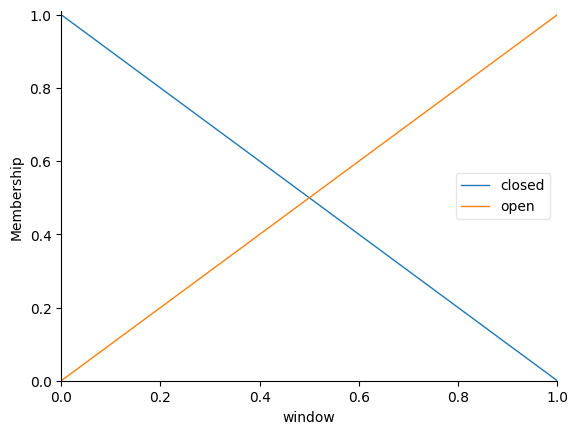

In [11]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

varijable = {
    "AQI":0,
    "DaLiPadaKisa":False,
    "BrzinaVjetra":0,
    "VlaznostZraka":0,
    "TemperaturaZraka":0
}

vektor = np.array(list(varijable.values()))

"""vektor = []
for a in varijable:
    vektor.append(varijable[a])"""
    
"""vektor = [
    varijable["AQI"],
    varijable["BrzinaVjetra"],
    varijable["DaLiPadaKisa"],
    varijable["TemperaturaZraka"],
    varijable["VlaznostZraka"]
]"""
print(varijable)
print(vektor)

def do_fuzzy(vektor):
    val = 0
    # Define input variables
    temperature = ctrl.Antecedent(np.arange(-40, 81, 1), 'temperature')
    humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

    # Define output variable
    window = ctrl.Consequent(np.arange(0, 2, 1), 'window')  # 0 = closed, 1 = open


    # Temperature membership
    temperature['cold'] = fuzz.trimf(temperature.universe, [-40, -40, 15])
    temperature['warm'] = fuzz.trimf(temperature.universe, [10, 25, 40])
    temperature['hot'] = fuzz.trimf(temperature.universe, [35, 80, 80])

    # Humidity membership
    humidity['dry'] = fuzz.trimf(humidity.universe, [0, 0, 50])
    humidity['humid'] = fuzz.trimf(humidity.universe, [30, 100, 100])

    # Window control
    window['closed'] = fuzz.trimf(window.universe, [0, 0, 1])
    window['open'] = fuzz.trimf(window.universe, [0, 1, 1])


    rule1 = ctrl.Rule(temperature['hot'] & humidity['dry'], window['open'])
    rule2 = ctrl.Rule(temperature['cold'] | humidity['humid'], window['closed'])

    # Create control system
    window_ctrl = ctrl.ControlSystem([rule1, rule2])
    window_sim = ctrl.ControlSystemSimulation(window_ctrl)

    # Set input values
    window_sim.input['temperature'] = 35
    window_sim.input['humidity'] = 30
    print("Inputs before compute:", window_sim.input)
    # Compute result
    window_sim.compute()

    #print("Window state (0=closed, 1=open):", window_sim.output["window"])
    temperature.view()
    humidity.view()
    window.view()
    return val


do_fuzzy(vektor)



### ZAKLJUČAK I KRATKA REFLEKSIJA

### IZVORI

1. https://www.winter.hr/automatika.htm
1. https://cdn.sparkfun.com/assets/f/7/d/9/c/DHT22.pdf
1. https://waqi.info/#/c/3.396/8.206/2.2z



### ULOGE ČLANOVA